# Probabilistic Signal Estimator

The question we want to answer is the following. How long does it take to reach +2% gain from now?

In [1]:
from hypecommons import *
from datetime import datetime, timedelta

In [2]:
CRYPTO = 'VET'
FIAT = 'BUSD'
SYMBOL = f"{CRYPTO}{FIAT}"
FREQ = 1
START = '20210101000000'
TARGET = 1.02
DAYS = 150

In [3]:
signal_cat = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW', 'VERY LOW']
signal_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

good_signals = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW']

In [4]:
from IPython.display import display, HTML
display(HTML(f"<center><img style='display: flex;' src='../img/symbols/{CRYPTO}.png'></center>"))

## Optimisation

In [5]:
df = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

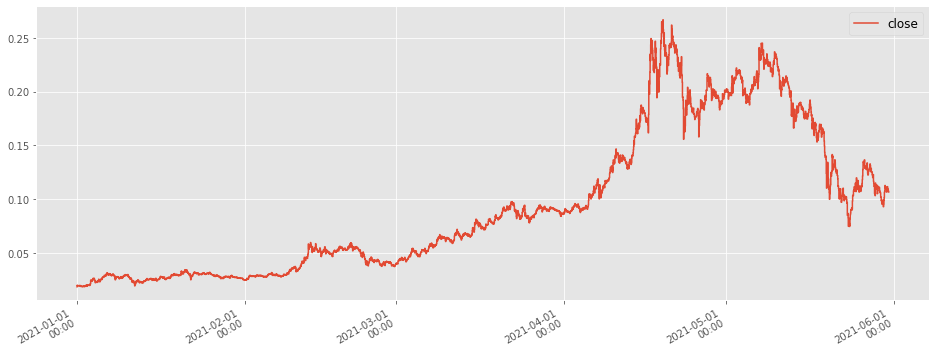

In [6]:
plot(plt.plot, df[::int(len(df)/3000)], ['close'], fig_size=(16, 6))

In [7]:
print(str(df.iloc[0]) + '\n\n' + str(df.iloc[-1]))

open      0.018746
high      0.018746
low       0.018746
close     0.018746
volume    0.000000
trades    0.000000
Name: 2021-01-01 00:00:00, dtype: float64

open           0.10750
high           0.10750
low            0.10646
close          0.10660
volume    105112.80000
trades        54.00000
Name: 2021-05-31 01:00:00, dtype: float64


As the goal is to achieve a given value, the `high` price value is used. Binance allows users to create future orders with a limit, therefore this behaviour can be reproduced also in a real-time setting.

In [8]:
def minutes_to_target(df, start, target):
    t0 = df.index[start]
    close0 = df['close'].iloc[start]
    try:
        t1 = df[(df.index > t0) & (df['high'] >= target * close0)].index[0]
    except IndexError:
        return None, None # it never achieves the target
    return t1, round((t1 - t0).total_seconds() / 60.0)

In [9]:
x0 = minutes_to_target(df, 0, target=TARGET)
print(x0)
df.iloc[int(x0[1]/FREQ)]['high'] / df.iloc[0]['close']

(Timestamp('2021-01-01 00:57:00'), 57)


1.0240584658060385

In [10]:
mins2tgt = []

rng = range(len(df))[::100]

for i in tqdm(rng, desc='Testing minutes to target...', ncols=100):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        mins2tgt.append(y)

Testing minutes to target...: 100%|████████████████████████████| 2154/2154 [00:07<00:00, 287.95it/s]


In [11]:
df_m = pd.DataFrame(mins2tgt)
pos, total = len(df_m[df_m[0] <= 600]), len(df_m)
print(f"In {pos} cases out of {total} (~{pos/total*100:.0f}%), 2% gain is reached after less than 10 hours.")

In 1549 cases out of 2080 (~74%), 2% gain is reached after less than 10 hours.


First 10 bins: [977. 311. 141.  90.  65.  48.  44.  22.  23.  21.]


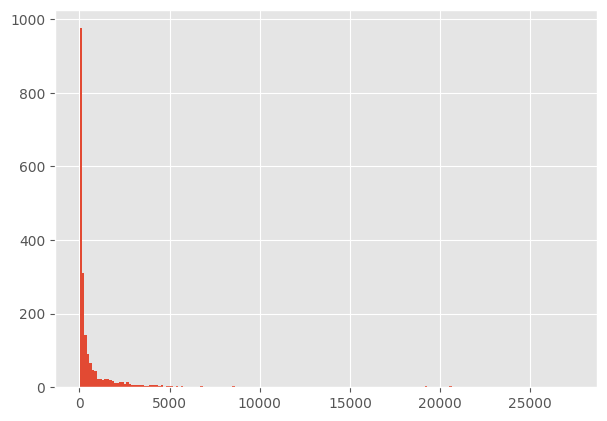

In [12]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (7,5), 'figure.dpi': 100})

n_bins = 200
hist_x, hist_y, hist_z = plt.hist(mins2tgt, bins=n_bins)

print(f"First 10 bins: {hist_x[:10]}")

In [13]:
print(f"Each bin represents around 60000/{n_bins} = {60000/n_bins} minutes = {60000/n_bins/60} hours of time,\n"
      f"which means {sum(hist_x[:1])/len(mins2tgt)*100:.1f}% of the time we reach +2% gain within {60000/n_bins/60} hours,\n"
      f"{sum(hist_x[:2])/len(mins2tgt)*100:.1f}% of the time within {2*60000/n_bins/60} hours, and so on.")


Each bin represents around 60000/200 = 300.0 minutes = 5.0 hours of time,
which means 47.0% of the time we reach +2% gain within 5.0 hours,
61.9% of the time within 10.0 hours, and so on.


In [14]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / FREQ
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

#         if field != 'close':
#             df.drop(field, axis=1, inplace=True)
    
    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
#     df.drop('close', axis=1, inplace=True)
    return df

In [15]:
df_n = normalise(df)
df_n

,open,high,low,close,volume,trades,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm
2021-01-01 00:00:00,0.018746,0.018746,0.018746,0.018746,0.0,0,1.000000,1.000000,1.000000,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.000000,1.000000
2021-01-01 00:01:00,0.018818,0.018839,0.018811,0.018839,30209.0,5,0.998885,1.000000,0.998514,30209.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0.995823,0.995429
2021-01-01 00:02:00,0.018839,0.018872,0.018785,0.018785,115373.0,13,1.002875,1.004631,1.000000,115373.0,48527.333333,NaN,13.0,6.000000,NaN,NaN,NaN,0.998888,0.998417
2021-01-01 00:03:00,0.018780,0.018780,0.018760,0.018760,18938.0,3,1.001066,1.001066,1.000000,18938.0,54840.000000,NaN,3.0,7.000000,NaN,NaN,NaN,1.000185,0.999766
2021-01-01 00:04:00,0.018766,0.018799,0.018766,0.018799,17268.0,3,0.998245,1.000000,0.998245,17268.0,50526.333333,NaN,3.0,6.333333,NaN,NaN,NaN,0.998401,0.997863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.107250,0.107510,0.107220,0.107270,62049.3,14,0.999814,1.002237,0.999534,62049.3,73370.066667,104863.255556,14.0,16.333333,21.444444,0.997556,1.007239,0.998221,0.998340
2021-05-31 00:57:00,0.107470,0.107860,0.107400,0.107710,61044.6,49,0.997772,1.001393,0.997122,61044.6,41031.300000,93708.300000,49.0,21.000000,24.000000,0.993731,1.003031,0.995044,0.994687
2021-05-31 00:58:00,0.107860,0.107860,0.107610,0.107610,79210.7,20,1.002323,1.002323,1.000000,79210.7,67434.866667,101354.544444,20.0,27.666667,24.666667,0.994921,1.003868,0.996589,0.995936
2021-05-31 00:59:00,0.107620,0.107620,0.107450,0.107500,33896.9,17,1.001116,1.001116,0.999535,33896.9,58050.733333,103803.366667,17.0,28.666667,25.888889,0.996138,1.004805,0.997977,0.997181


In [16]:
from joblib import Parallel, delayed  

def compute_mins(i):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        return y
    else:
        return 120000

mins2tgt = Parallel(n_jobs=4)(delayed(compute_mins)(i) for i in tqdm(range(len(df)), 
                                           desc='Computing minutes to target...', ncols=100))

df_n['mins2tgt'] = mins2tgt

Computing minutes to target...: 100%|██████████████████████| 215398/215398 [07:44<00:00, 463.88it/s]


In [17]:
df.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-raw-{TARGET}.csv")
df_n.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-norm-{TARGET}.csv")

In [18]:
df_n.dropna(inplace=True)
df_n

,open,high,low,close,volume,trades,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.019764,0.019764,0.019764,0.019764,6198.0,1,1.000000,1.000000,1.000000,6198.0,2252.666667,14437.111111,1.0,0.666667,1.777778,1.001929,0.986696,0.999877,1.000882,522
2021-01-01 03:20:00,0.019775,0.019775,0.019775,0.019775,657.0,1,1.000000,1.000000,1.000000,657.0,2285.000000,14510.111111,1.0,0.666667,1.888889,1.001462,0.986408,0.999425,1.000302,521
2021-01-01 03:21:00,0.019736,0.019736,0.019736,0.019736,561.0,1,1.000000,1.000000,1.000000,561.0,2472.000000,7106.777778,1.0,1.000000,1.666667,1.003380,0.988584,1.001185,1.002109,520
2021-01-01 03:22:00,0.019733,0.019733,0.019733,0.019733,867.0,1,1.000000,1.000000,1.000000,867.0,695.000000,7203.111111,1.0,1.000000,1.777778,1.003452,0.988975,1.001131,1.002094,519
2021-01-01 03:23:00,0.019733,0.019733,0.019733,0.019733,0.0,0,1.000000,1.000000,1.000000,0.0,476.000000,3084.555556,0.0,0.666667,1.111111,1.003326,0.989221,1.000957,1.001939,518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.107250,0.107510,0.107220,0.107270,62049.3,14,0.999814,1.002237,0.999534,62049.3,73370.066667,104863.255556,14.0,16.333333,21.444444,0.997556,1.007239,0.998221,0.998340,120000
2021-05-31 00:57:00,0.107470,0.107860,0.107400,0.107710,61044.6,49,0.997772,1.001393,0.997122,61044.6,41031.300000,93708.300000,49.0,21.000000,24.000000,0.993731,1.003031,0.995044,0.994687,120000
2021-05-31 00:58:00,0.107860,0.107860,0.107610,0.107610,79210.7,20,1.002323,1.002323,1.000000,79210.7,67434.866667,101354.544444,20.0,27.666667,24.666667,0.994921,1.003868,0.996589,0.995936,120000
2021-05-31 00:59:00,0.107620,0.107620,0.107450,0.107500,33896.9,17,1.001116,1.001116,0.999535,33896.9,58050.733333,103803.366667,17.0,28.666667,25.888889,0.996138,1.004805,0.997977,0.997181,120000


In [19]:
signal_cat = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW', 'VERY LOW']
signal_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

def find_quantiles(df_q):
    quantiles = []
    for c, q in zip(signal_cat, signal_thr):
        quantiles.append({'cat': c, 'quantile': q, 'value': df_q['mins2tgt'].quantile(q)})
    return quantiles

quantiles = find_quantiles(df_n)
quantiles

print(f"Everything higher than {quantiles[-2]['value']} will be treated as VERY LOW, therefore we can remove\n"
      f"the last rows within such interval.")

Everything higher than 1255.0 will be treated as VERY LOW, therefore we can remove
the last rows within such interval.


In [20]:
remove_after_this = df_n.index[-1] - timedelta(minutes=quantiles[-2]['value'])
df_ml = df_n[df_n.index < remove_after_this].copy()
df_ml

,open,high,low,close,volume,trades,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.019764,0.019764,0.019764,0.019764,6198.0,1,1.000000,1.000000,1.000000,6198.0,2252.666667,14437.111111,1.0,0.666667,1.777778,1.001929,0.986696,0.999877,1.000882,522
2021-01-01 03:20:00,0.019775,0.019775,0.019775,0.019775,657.0,1,1.000000,1.000000,1.000000,657.0,2285.000000,14510.111111,1.0,0.666667,1.888889,1.001462,0.986408,0.999425,1.000302,521
2021-01-01 03:21:00,0.019736,0.019736,0.019736,0.019736,561.0,1,1.000000,1.000000,1.000000,561.0,2472.000000,7106.777778,1.0,1.000000,1.666667,1.003380,0.988584,1.001185,1.002109,520
2021-01-01 03:22:00,0.019733,0.019733,0.019733,0.019733,867.0,1,1.000000,1.000000,1.000000,867.0,695.000000,7203.111111,1.0,1.000000,1.777778,1.003452,0.988975,1.001131,1.002094,519
2021-01-01 03:23:00,0.019733,0.019733,0.019733,0.019733,0.0,0,1.000000,1.000000,1.000000,0.0,476.000000,3084.555556,0.0,0.666667,1.111111,1.003326,0.989221,1.000957,1.001939,518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 04:00:00,0.099030,0.099270,0.098880,0.099270,88678.9,37,0.997582,1.000000,0.996071,88678.9,132447.533333,112307.655556,37.0,27.000000,21.333333,0.987239,0.970958,0.994469,0.991845,48
2021-05-30 04:01:00,0.099290,0.099910,0.099290,0.099600,40470.9,45,0.996888,1.003112,0.996888,40470.9,119079.866667,79674.500000,45.0,35.666667,21.666667,0.984610,0.967737,0.992532,0.989406,49
2021-05-30 04:02:00,0.099660,0.099720,0.099200,0.099380,33236.1,17,1.002817,1.003421,0.998189,33236.1,54128.633333,74847.911111,17.0,33.000000,20.666667,0.987388,0.969882,0.995540,0.992219,48
2021-05-30 04:03:00,0.099420,0.099590,0.099200,0.099380,76420.0,32,1.000402,1.002113,0.998189,76420.0,50042.333333,66439.655556,32.0,31.333333,23.666667,0.988010,0.969892,0.996226,0.992795,47


In [21]:
df_ml.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-ml-{TARGET}.csv")

## Load from file

In [22]:
import pandas as pd

df = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

df_ml = pd.read_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-ml-{TARGET}.csv").set_index('Unnamed: 0')
df_ml = df_ml.set_index(pd.to_datetime(df_ml.index))
df_ml

,open,high,low,close,volume,trades,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.019764,0.019764,0.019764,0.019764,6198.0,1,1.000000,1.000000,1.000000,6198.0,2252.666667,14437.111111,1.0,0.666667,1.777778,1.001929,0.986696,0.999877,1.000882,522
2021-01-01 03:20:00,0.019775,0.019775,0.019775,0.019775,657.0,1,1.000000,1.000000,1.000000,657.0,2285.000000,14510.111111,1.0,0.666667,1.888889,1.001462,0.986408,0.999425,1.000302,521
2021-01-01 03:21:00,0.019736,0.019736,0.019736,0.019736,561.0,1,1.000000,1.000000,1.000000,561.0,2472.000000,7106.777778,1.0,1.000000,1.666667,1.003380,0.988584,1.001185,1.002109,520
2021-01-01 03:22:00,0.019733,0.019733,0.019733,0.019733,867.0,1,1.000000,1.000000,1.000000,867.0,695.000000,7203.111111,1.0,1.000000,1.777778,1.003452,0.988975,1.001131,1.002094,519
2021-01-01 03:23:00,0.019733,0.019733,0.019733,0.019733,0.0,0,1.000000,1.000000,1.000000,0.0,476.000000,3084.555556,0.0,0.666667,1.111111,1.003326,0.989221,1.000957,1.001939,518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 04:00:00,0.099030,0.099270,0.098880,0.099270,88678.9,37,0.997582,1.000000,0.996071,88678.9,132447.533333,112307.655556,37.0,27.000000,21.333333,0.987239,0.970958,0.994469,0.991845,48
2021-05-30 04:01:00,0.099290,0.099910,0.099290,0.099600,40470.9,45,0.996888,1.003112,0.996888,40470.9,119079.866667,79674.500000,45.0,35.666667,21.666667,0.984610,0.967737,0.992532,0.989406,49
2021-05-30 04:02:00,0.099660,0.099720,0.099200,0.099380,33236.1,17,1.002817,1.003421,0.998189,33236.1,54128.633333,74847.911111,17.0,33.000000,20.666667,0.987388,0.969882,0.995540,0.992219,48


In [23]:
quantiles = find_quantiles(df_ml)
quantiles

[{'cat': 'VERY HIGH', 'quantile': 0.2, 'value': 38.0},
 {'cat': 'HIGH', 'quantile': 0.4, 'value': 107.0},
 {'cat': 'NORMAL', 'quantile': 0.6, 'value': 282.0},
 {'cat': 'LOW', 'quantile': 0.8, 'value': 1241.0},
 {'cat': 'VERY LOW', 'quantile': 1.0, 'value': 120000.0}]

In [24]:
df_ml['cat'] = None

def to_cat(x):
    for q in reversed(quantiles):
        if x <= q['value']:
            res = q['cat']
    return res

df_ml['cat'] = df_ml['mins2tgt'].map(to_cat)
df_ml

,open,high,low,close,volume,trades,open_norm,high_norm,low_norm,volume_pm_ma1,...,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt,cat
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.019764,0.019764,0.019764,0.019764,6198.0,1,1.000000,1.000000,1.000000,6198.0,...,14437.111111,1.0,0.666667,1.777778,1.001929,0.986696,0.999877,1.000882,522,LOW
2021-01-01 03:20:00,0.019775,0.019775,0.019775,0.019775,657.0,1,1.000000,1.000000,1.000000,657.0,...,14510.111111,1.0,0.666667,1.888889,1.001462,0.986408,0.999425,1.000302,521,LOW
2021-01-01 03:21:00,0.019736,0.019736,0.019736,0.019736,561.0,1,1.000000,1.000000,1.000000,561.0,...,7106.777778,1.0,1.000000,1.666667,1.003380,0.988584,1.001185,1.002109,520,LOW
2021-01-01 03:22:00,0.019733,0.019733,0.019733,0.019733,867.0,1,1.000000,1.000000,1.000000,867.0,...,7203.111111,1.0,1.000000,1.777778,1.003452,0.988975,1.001131,1.002094,519,LOW
2021-01-01 03:23:00,0.019733,0.019733,0.019733,0.019733,0.0,0,1.000000,1.000000,1.000000,0.0,...,3084.555556,0.0,0.666667,1.111111,1.003326,0.989221,1.000957,1.001939,518,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 04:00:00,0.099030,0.099270,0.098880,0.099270,88678.9,37,0.997582,1.000000,0.996071,88678.9,...,112307.655556,37.0,27.000000,21.333333,0.987239,0.970958,0.994469,0.991845,48,HIGH
2021-05-30 04:01:00,0.099290,0.099910,0.099290,0.099600,40470.9,45,0.996888,1.003112,0.996888,40470.9,...,79674.500000,45.0,35.666667,21.666667,0.984610,0.967737,0.992532,0.989406,49,HIGH
2021-05-30 04:02:00,0.099660,0.099720,0.099200,0.099380,33236.1,17,1.002817,1.003421,0.998189,33236.1,...,74847.911111,17.0,33.000000,20.666667,0.987388,0.969882,0.995540,0.992219,48,HIGH


In [25]:
str(list(df_ml.columns))

"['open', 'high', 'low', 'close', 'volume', 'trades', 'open_norm', 'high_norm', 'low_norm', 'volume_pm_ma1', 'volume_pm_ma3', 'volume_pm_ma9', 'trades_pm_ma1', 'trades_pm_ma3', 'trades_pm_ma9', 'close_ma50_norm', 'close_ma200_norm', 'close_ema12_norm', 'close_ema26_norm', 'mins2tgt', 'cat']"

In [26]:
feat_cols = ['open_norm', 'high_norm', 'low_norm', 'volume_pm_ma1', 'volume_pm_ma3', 
             'volume_pm_ma9', 'trades_pm_ma1', 'trades_pm_ma3', 'trades_pm_ma9', 
             'close_ma50_norm', 'close_ma200_norm', 'close_ema12_norm', 'close_ema26_norm']
df_ml_feats = df_ml[feat_cols]

## Signal detection

Each dot is a moment between Jan 1st and June 1st this year. The blue dots are moments with a high buy signal where the price went +2% in less than 30 hours (`VERY HIGH`, `HIGH`, `NORMAL`, and `LOW` categories). My aim is to detect them automatically.

open_norm


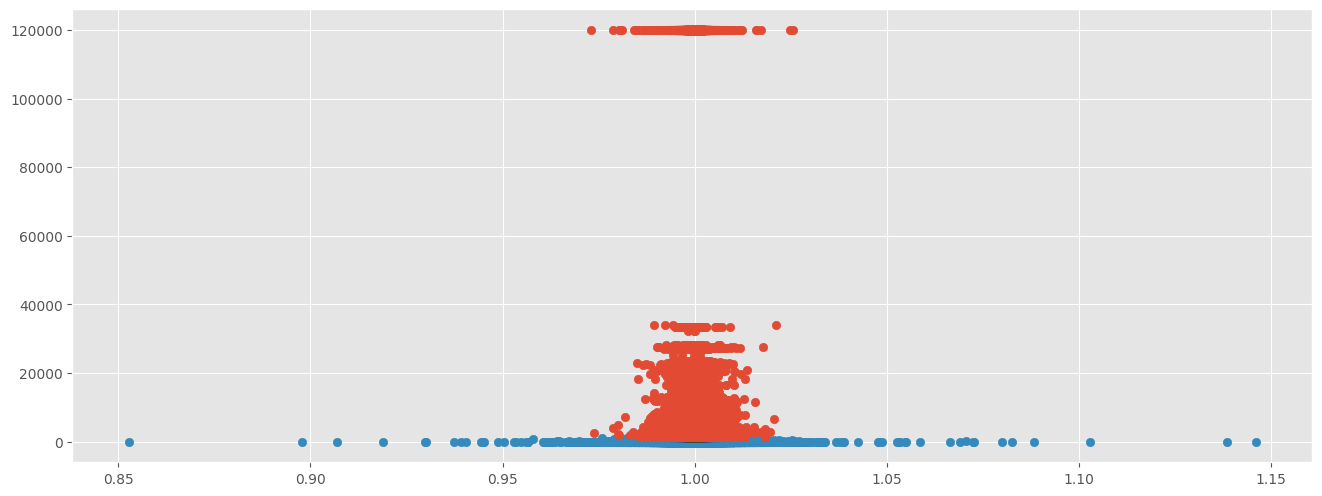

high_norm


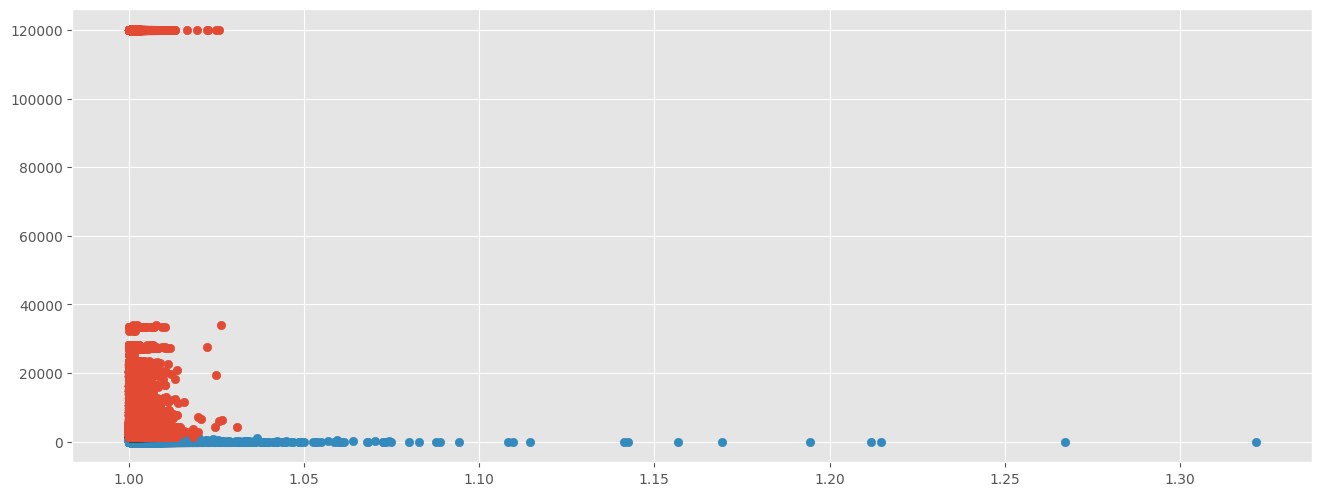

low_norm


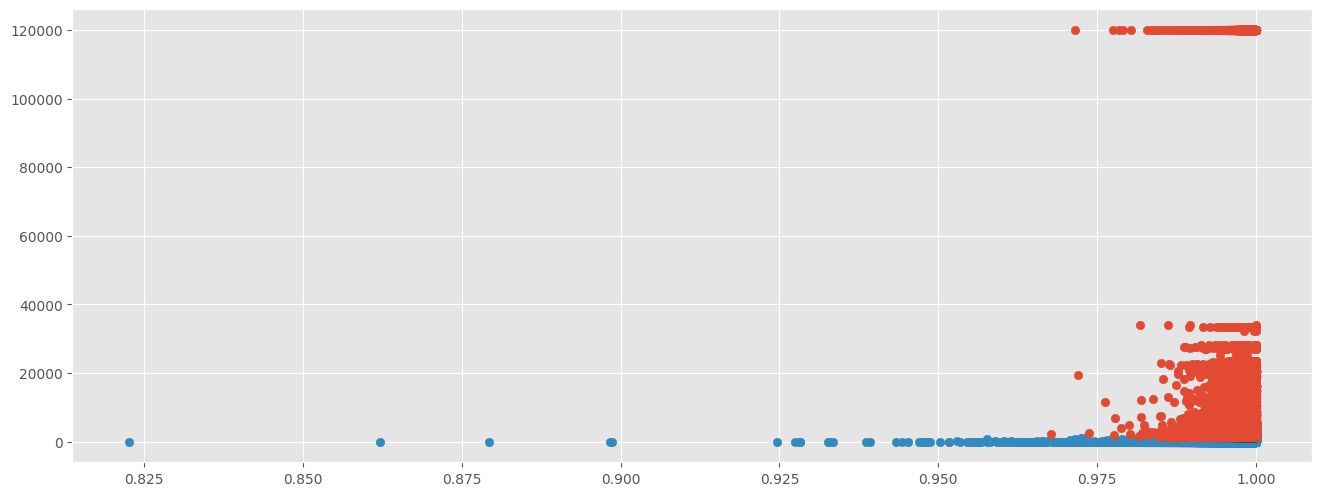

volume_pm_ma1


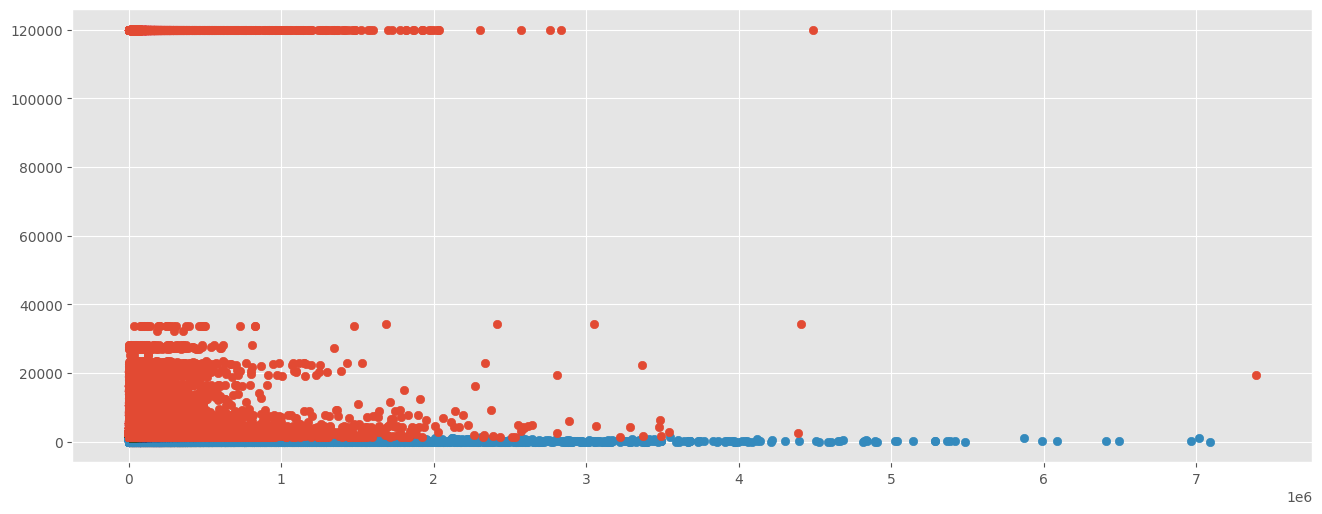

volume_pm_ma3


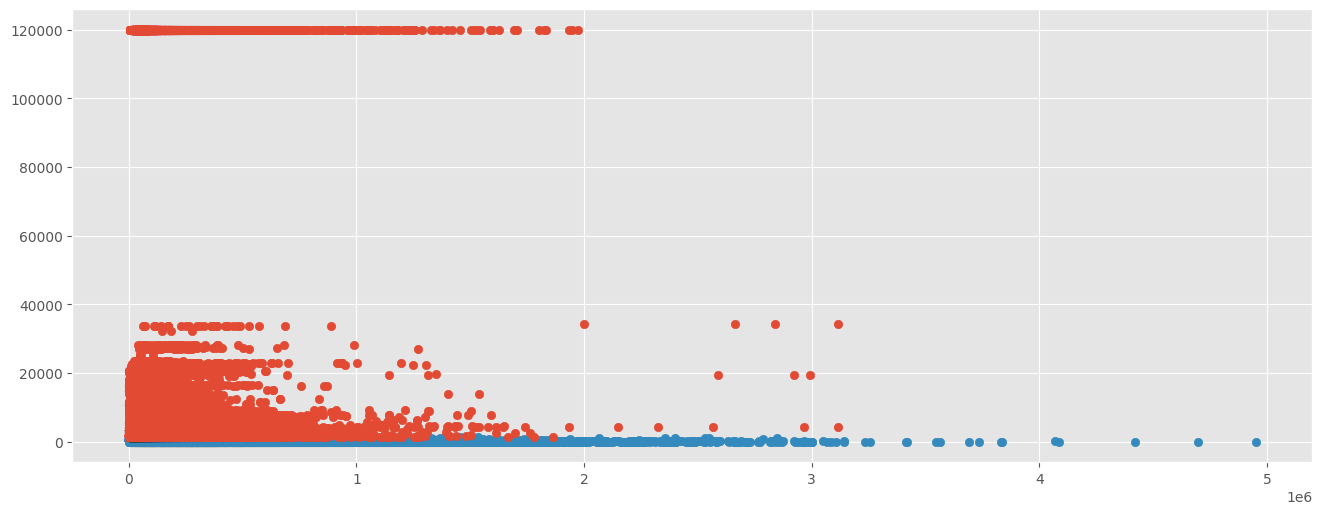

volume_pm_ma9


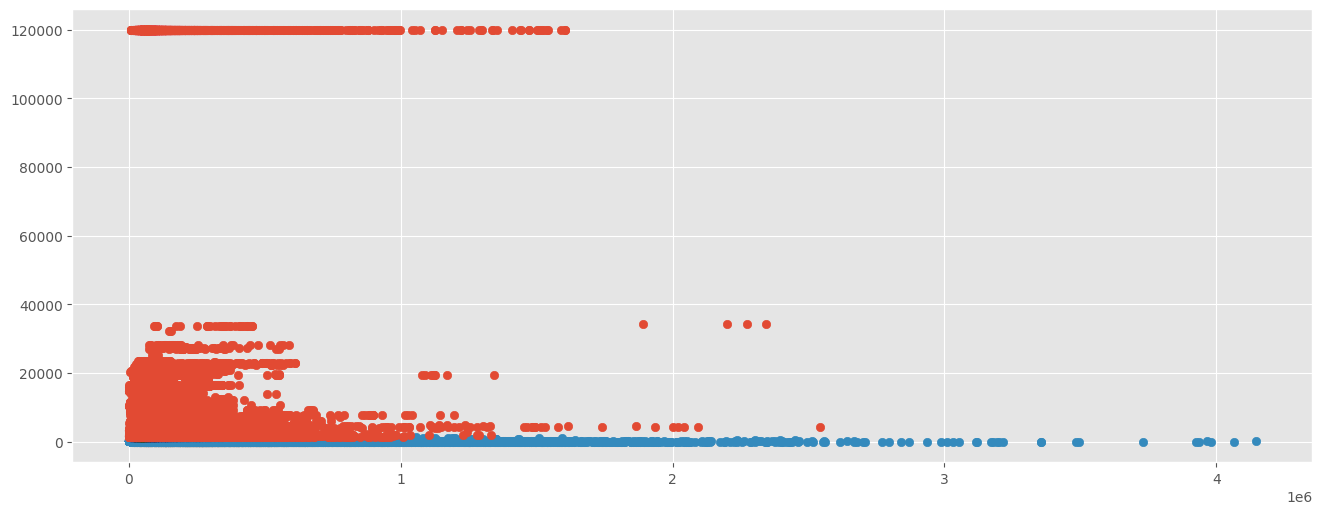

trades_pm_ma1


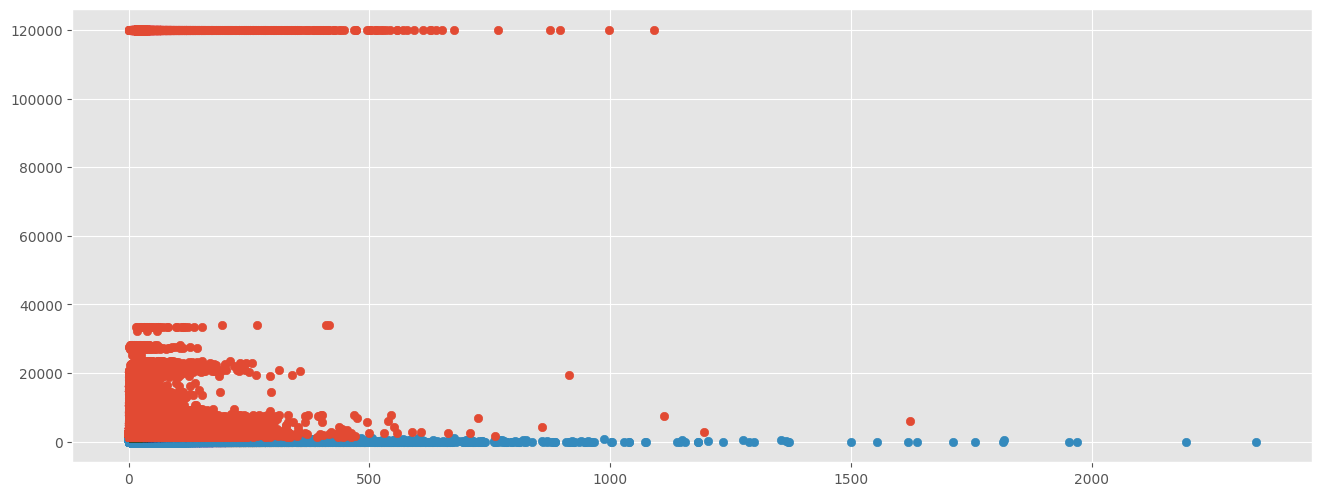

trades_pm_ma3


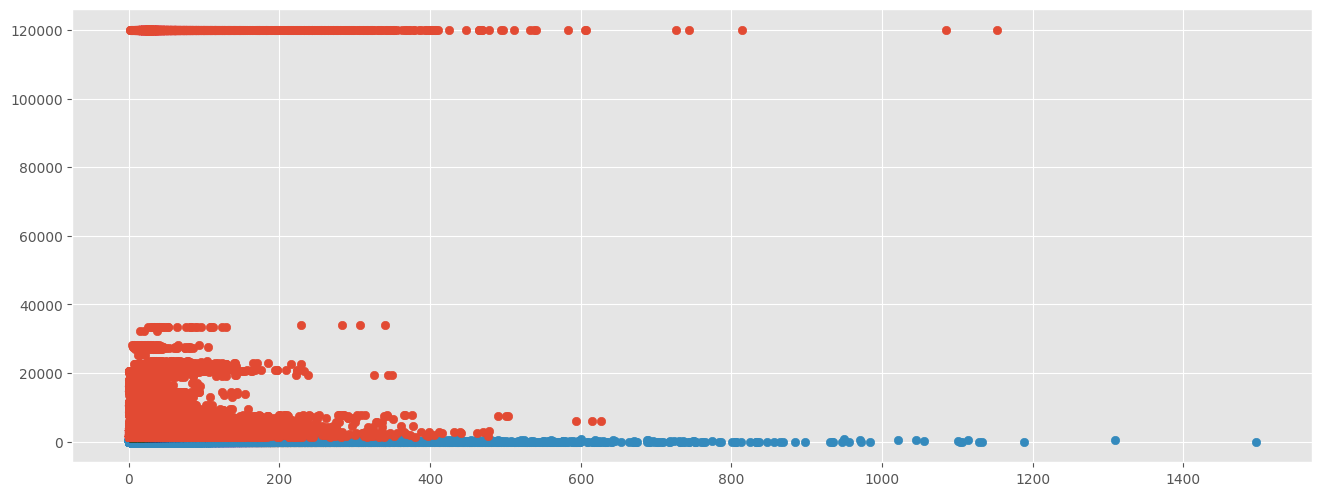

trades_pm_ma9


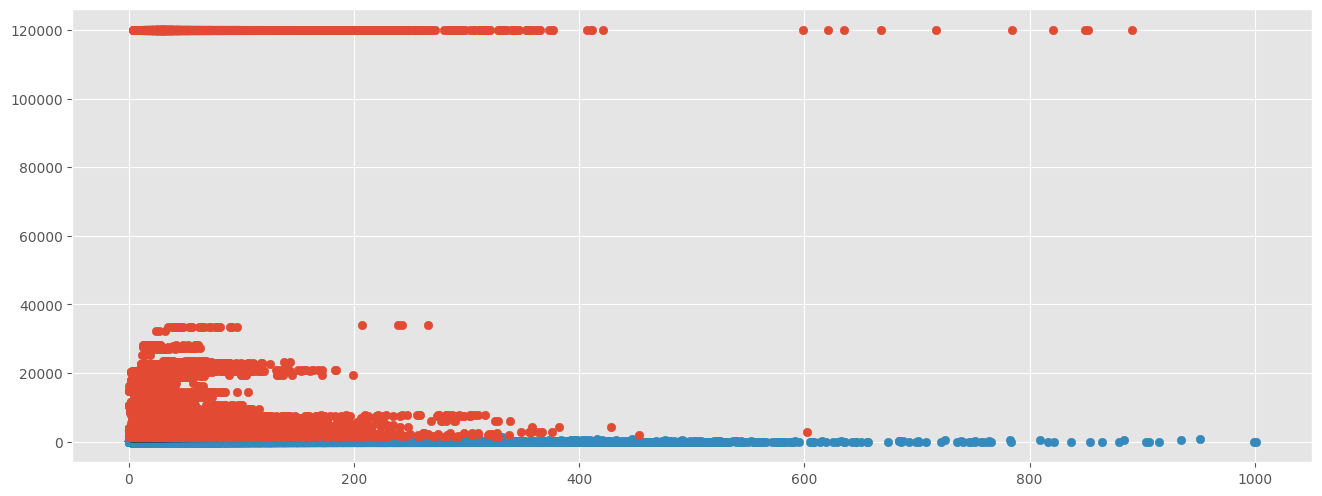

close_ma50_norm


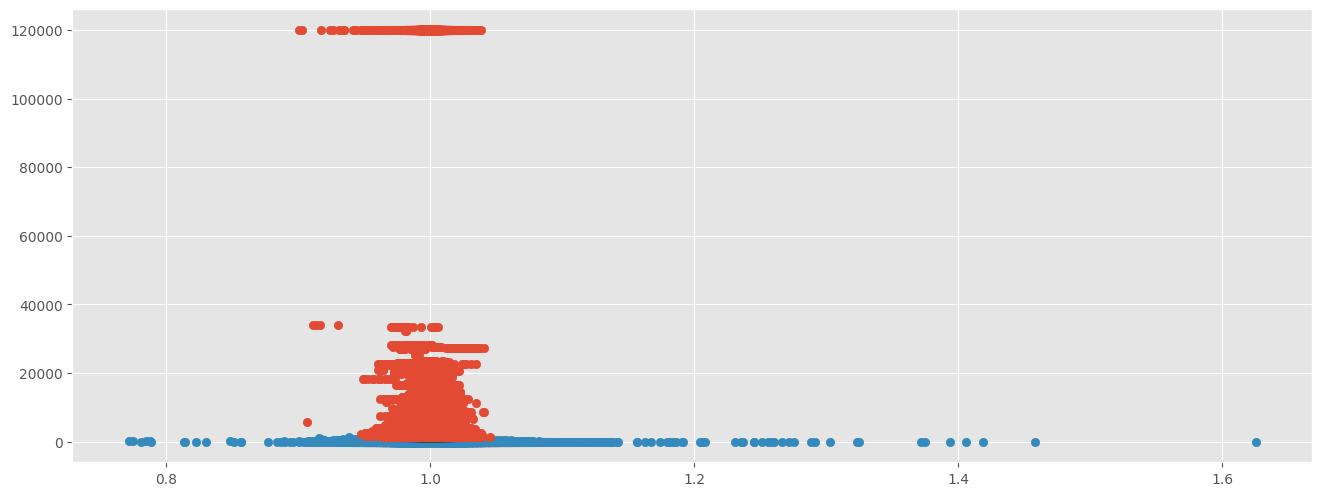

close_ma200_norm


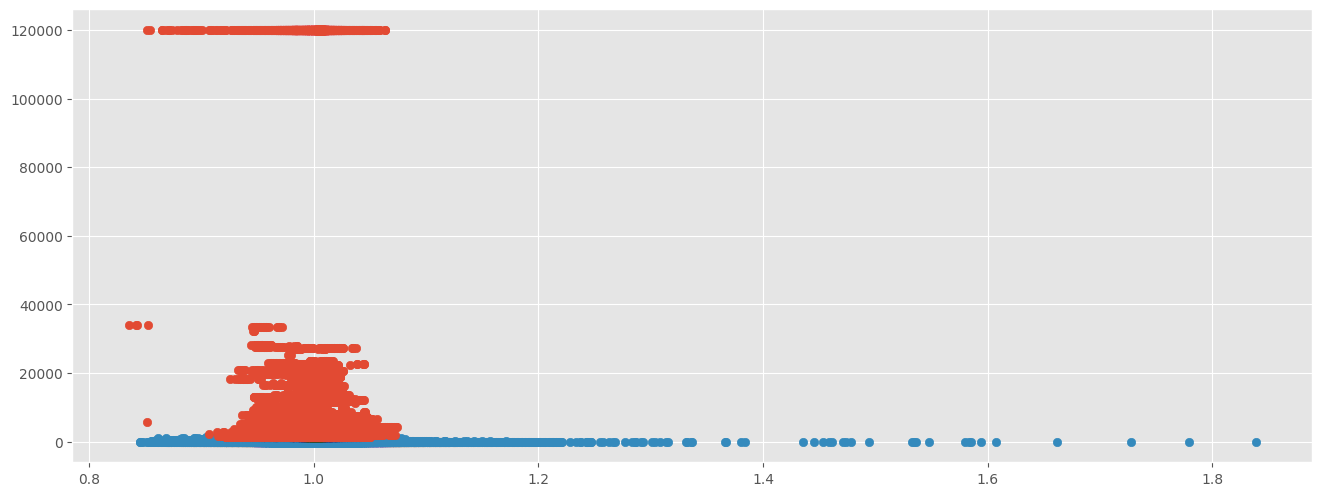

close_ema12_norm


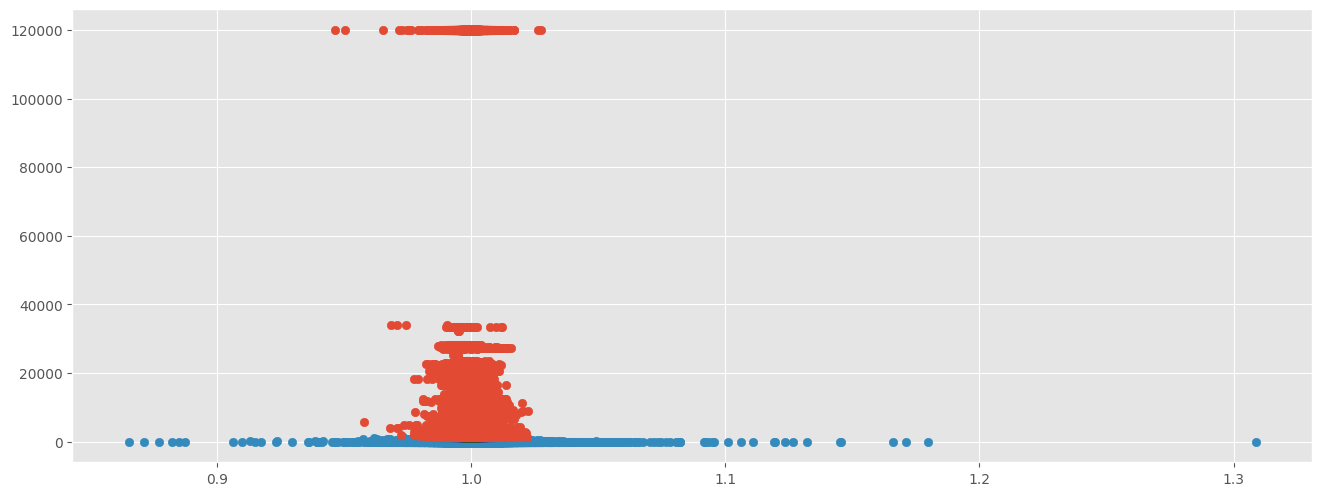

close_ema26_norm


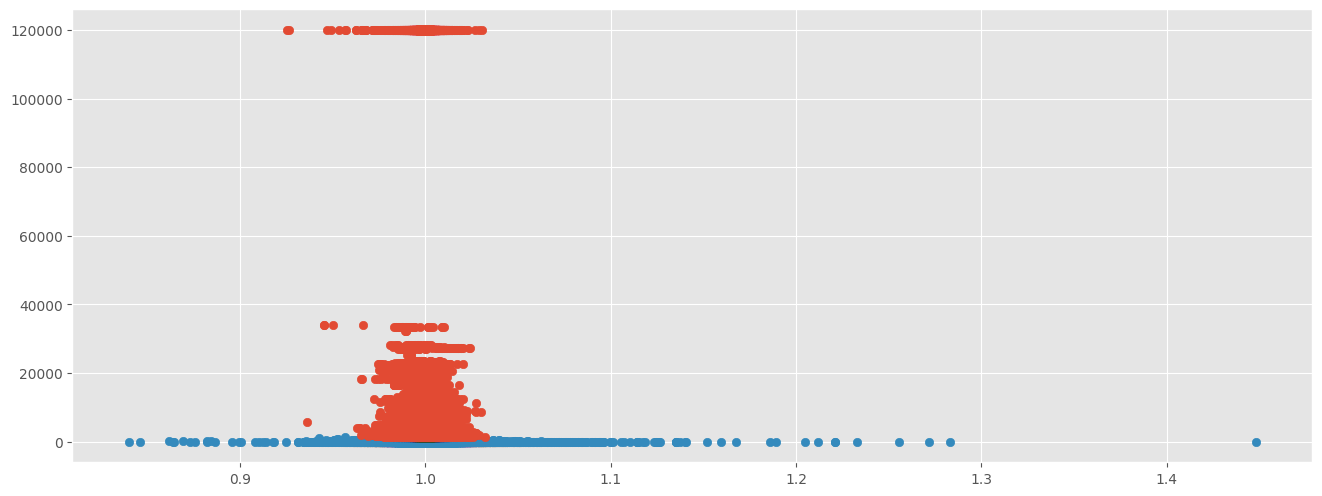

In [27]:
# beware of y=120k (which means 'never reaches +2%') and high y values (exceptionally bad points)

import matplotlib.pyplot as plt

df_plot = df_ml.copy()

plt.rcParams["figure.figsize"] = (16, 6)

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot negatives over positives to spot them better
for fc in feat_cols:
    print(fc)
    # blue dots = buy signals
    plt.scatter(df_plot[df_plot['cat'].isin(good_signals)][fc], 
                df_plot[df_plot['cat'].isin(good_signals)]['mins2tgt'], c=palette[1])
    # red dots = idle signals
    plt.scatter(df_plot[~df_plot['cat'].isin(good_signals)][fc], 
                df_plot[~df_plot['cat'].isin(good_signals)]['mins2tgt'], c=palette[0])
    plt.show()

rsi14


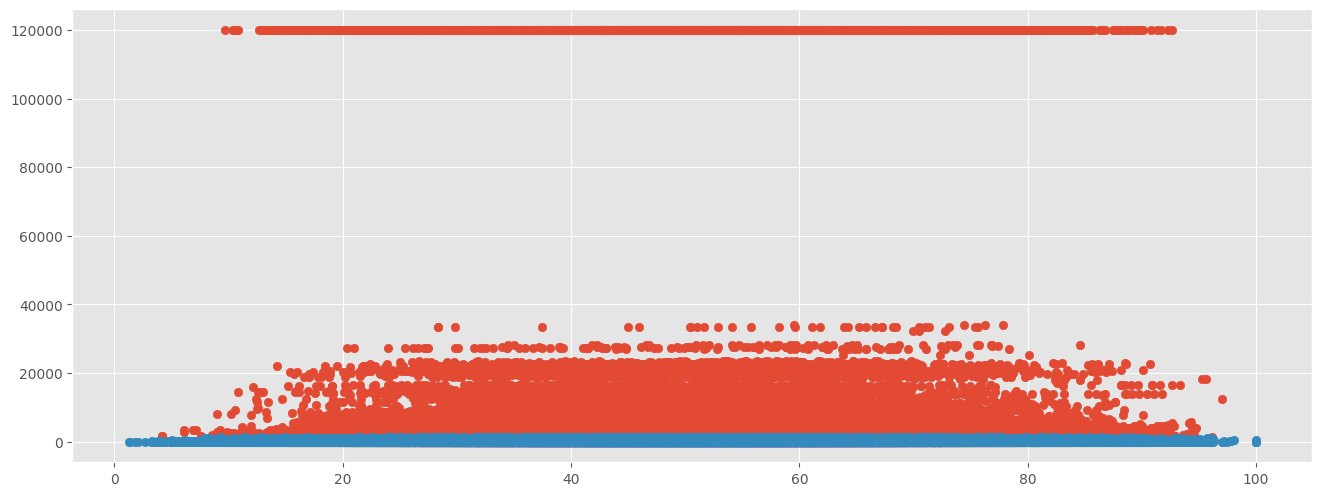

In [28]:
def rsi(data, n):
    # Make the positive gains (up) and negative gains (down) Series
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=n).mean()
    roll_down1 = down.abs().ewm(span=n).mean()

    # Calculate the RSI based on EWMA
    rs1 = roll_up1 / roll_down1
    return 100.0 - (100.0 / (1.0 + rs1))

df_plot['rsi14'] = rsi(df_plot['close'], 14)

for fc in ['rsi14']:
    print(fc)
    # red dots = idle signals
    plt.scatter(df_plot[~df_plot['cat'].isin(good_signals)][fc], 
                df_plot[~df_plot['cat'].isin(good_signals)]['mins2tgt'])
    # blue dots = buy signals
    plt.scatter(df_plot[df_plot['cat'].isin(good_signals)][fc], 
                df_plot[df_plot['cat'].isin(good_signals)]['mins2tgt'])
    plt.show()

## Threshold study

In [29]:
def threshold_study(field, val_min, val_max, target):
    thrs = np.arange(val_min, val_max, 0.005)
    precs = []
    for thr in thrs:
        goods = len(df_ml[(df_ml[field] >= thr) & (df_ml['cat'].isin(good_signals))])
        bads = len(df_ml[(df_ml[field] >= thr) & (~df_ml['cat'].isin(good_signals))])
        prec = goods / (goods + bads) if goods + bads > 0 else 0
#         rec = goods / relevants
        precs.append(prec if target == 'p' else goods / DAYS)
    
    plt.plot(thrs, precs, label=field)
    if target == 's':
        plt.yscale('log')

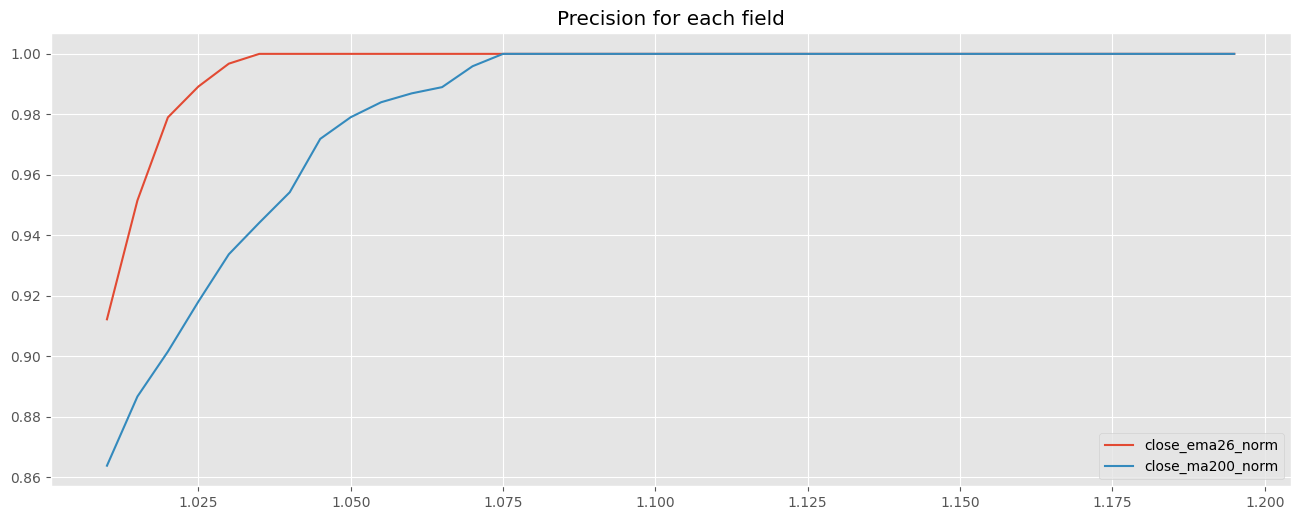

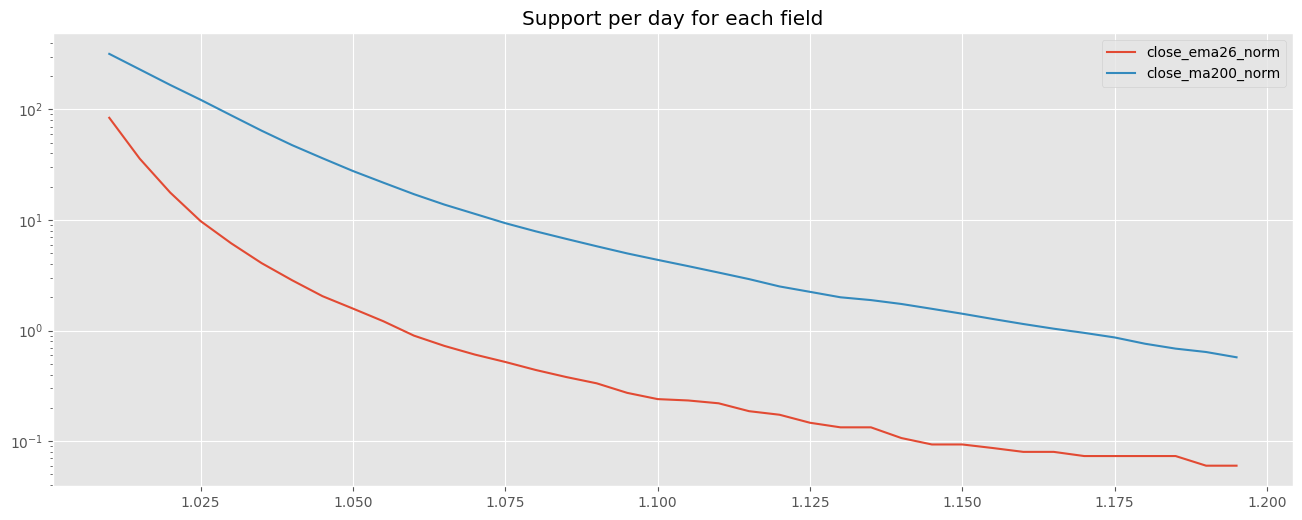

In [30]:
threshold_study('close_ema26_norm', 1.01, 1.2, 'p')
threshold_study('close_ma200_norm', 1.01, 1.2, 'p')
plt.legend(loc="best")
plt.title(f"Precision for each field")
plt.show()

threshold_study('close_ema26_norm', 1.01, 1.2, 's')
threshold_study('close_ma200_norm', 1.01, 1.2, 's')
plt.legend(loc="best")
plt.title(f"Support per day for each field")
plt.show()

## Binary model tracing

In [31]:
df_ml_feats_subset = df_ml_feats[['close_ema26_norm', 'close_ma200_norm']].copy()
df_ml_feats_binary = pd.DataFrame(df_ml['cat'].isin(good_signals))

In [52]:
from math import cos, sin, pi

def parabole_model(X, Y, decfun=False):
    Tx = -0.809
    Ty = -0.234
    F = (12*(X+Tx) - 3*(Y+Ty))**2 + (X+Tx) + (Y+Ty) - 1
    return F if decfun else F >= 0

def soru_viga_ellipse(X, Y, decfun=False):
    A = .018
    B = .052
    x = X - 1.
    y = Y - .995
    alpha = -pi/14
    F = (x * cos(alpha) + y * sin(alpha)) ** 2 / A ** 2 + (x * sin(alpha) - y * cos(alpha)) ** 2 / B ** 2 - 1
    return F if decfun else F >= 0

# ---------------------------------------------------------------

def is_good_signal(X, Y, decfun=False):
#     return parabole_model(X, Y, decfun=decfun)
    return soru_viga_ellipse(X, Y, decfun=decfun)

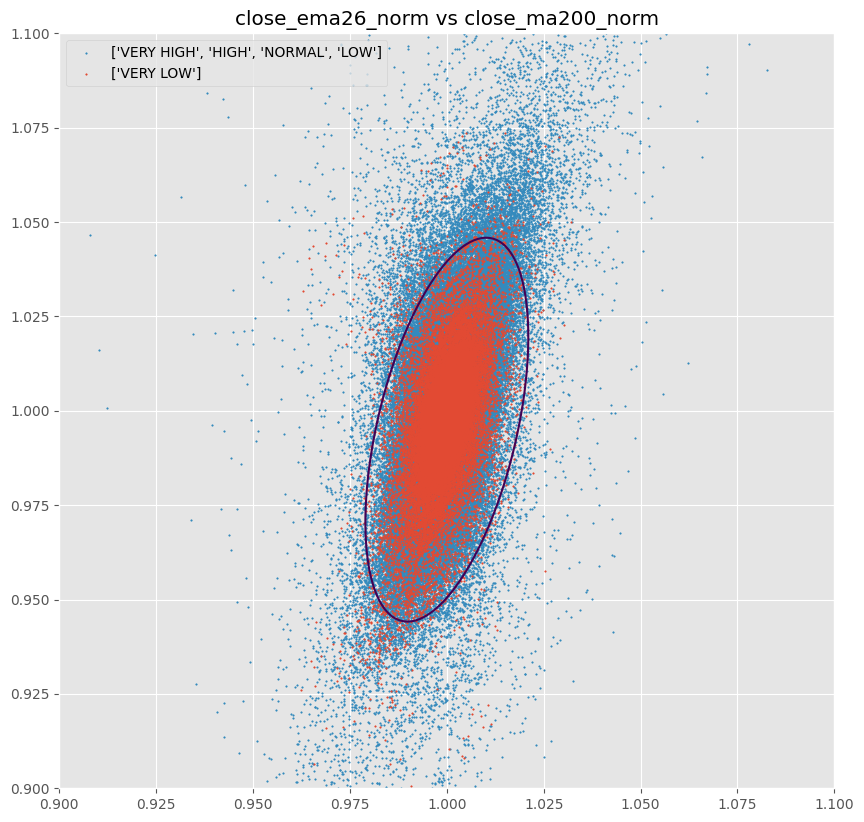

In [104]:
plt.figure(figsize=(10, 10))

bad_signals = ['VERY LOW']

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  
to_col = {1: good_signals, 0: bad_signals}

delta = 0.001
xy_min, xy_max = 0.9, 1.1
xrange = np.arange(xy_min, xy_max, delta)
yrange = np.arange(xy_min, xy_max, delta)
X, Y = np.meshgrid(xrange,yrange)

F = is_good_signal(X, Y, decfun=True)
plt.contour(X, Y, F, [0])

for c, cl in to_col.items():
    selection = df_ml['cat'].isin(cl)
    plt.scatter(df_ml_feats[selection]['close_ema26_norm'], 
                df_ml_feats[selection]['close_ma200_norm'], 
                s=1, c=palette[c], label=cl)

plt.legend(loc="upper left")
plt.title("close_ema26_norm vs close_ma200_norm")
plt.gca().set_xlim([xy_min, xy_max])
plt.gca().set_ylim([xy_min, xy_max])
plt.show()

Evaluating precision...: 100%|████████████████████████████| 213943/213943 [00:23<00:00, 9199.74it/s]


{'pre': 0.9370132844709116, 'tp': 12273, 'fp': 825, 'tp/day': 81.82}
Unique days with prospect of +2%: 126


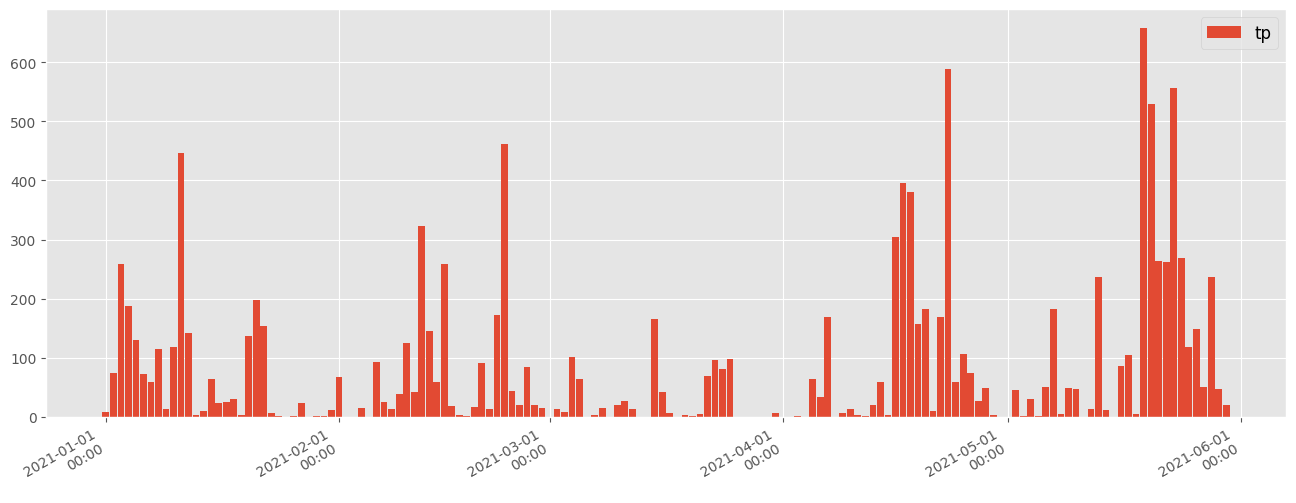

In [102]:
from collections import Counter

tp, fp = 0, 0

true_positive = []

for (_, X), (_, y) in tqdm(zip(df_ml_feats_subset.iterrows(), df_ml_feats_binary.iterrows()), 
                           desc='Evaluating precision...', total=len(df_ml_feats_subset), ncols=100):
#     print(X['close_ema26_norm'], X['close_ma200_norm'], y['cat'])
    if is_good_signal(X['close_ema26_norm'], X['close_ma200_norm']):
        if y['cat']:
            tp += 1
            true_positive.append(True)
        else:
            fp += 1
            true_positive.append(False)
    else:
        true_positive.append(False)

df_ml_feats_subset['tp'] = true_positive
df_tp = df_ml_feats_subset[df_ml_feats_subset['tp'] == True].copy()
df_tp['date'] = pd.to_datetime(df_tp.index)

evaluation = {'pre': tp/(tp+fp), 'tp': tp, 'fp': fp, 'tp/day': tp/DAYS}

print(evaluation)

c = Counter()

for i, row in df_tp.iterrows():
    c[(row['date'].year, row['date'].month, row['date'].day)] += 1

print(f"Unique days with prospect of +2%: {len(c)}")
# print(f"Total predicted change: {(1.02 ** len(c) - 1) * evaluation['pre']:+.1%}")

start = pd.to_datetime(df_ml_feats_subset.index[0])
end = pd.to_datetime(df_ml_feats_subset.index[-1])

t = start
datedist = []

while True:
    datedist.append({'date': datetime(t.year, t.month, t.day), 'tp': c[(t.year, t.month, t.day)]})
    t = t + timedelta(days=1)
    if t >= end:
        break

df_datedist = pd.DataFrame.from_records(datedist, index='date')

plot(plt.bar, df_datedist, ['tp'], bar_size=.9, fig_size=(16, 6))

## Simulation & parameter optimisation

In [150]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / FREQ
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
    return df

def simulate(df_sim, target=1.02, stop=0.94, hrs_frozen=0, fees=0.001):
    stake = [1]
    action = []
    invested = False
    frozen = False
    for i, row in tqdm(df_sim.iterrows(), desc='Simulating...', ncols=100, total=len(df_sim)):
        if frozen and i >= last_loss + timedelta(hours=hrs_frozen):
            frozen = False
        if frozen and i < last_loss + timedelta(hours=hrs_frozen):
            stake.append(stake[-1])
            action.append('FROZEN')
        elif row['pred'] and not invested:
            stake.append(stake[-1] * (1-fees))
            invested = True
            take_profit = row['close'] * target
            stop_loss = row['close'] * stop
            action.append('BUY')
        elif invested:
            if row['high'] > take_profit:
                invested = False
                action.append('PROFIT')
                stake.append(stake[-1] / prev_close * take_profit)
            elif row['low'] < stop_loss:
                invested = False
                action.append('LOSS')
                stake.append(stake[-1] / prev_close * stop_loss)
                last_loss = i
                frozen = True
            else:
                stake.append(stake[-1] / prev_close * row['close'])
                action.append('----')
        else:
            stake.append(stake[-1])
            action.append('----')
        prev_close = row['close']
    df_sim['stake'] = stake[1:]
    df_sim['action'] = action
    return df_sim

In [151]:
def show_simulation(df_sim):
    display(df_sim[df_sim['action'].isin(['PROFIT', 'LOSS'])][
        ['close', 'close_ema26_norm', 'close_ma200_norm', 'stake', 'action']])

    df_sim[df_sim['action'].isin(['PROFIT', 'LOSS'])]['action'].str.get_dummies().sum().plot(
        kind='pie', label='action', autopct='%1.0f%%', figsize=[5, 5])
    plt.show()

    plot(plt.plot, df_sim, ['market', 'stake'], fig_size=(16, 6))

def run_simulation_on_data(df_sim, signal_function, target=1.02, stop=0.94, hrs_frozen=0, fees=0.001, show=True):
    df_sim = normalise(df_sim)
    df_sim.dropna(inplace=True)
    df_sim['pred'] = np.vectorize(signal_function)(df_sim['close_ema26_norm'], df_sim['close_ma200_norm'])
    df_sim = df_sim.set_index(pd.to_datetime(df_sim.index))

    # ------- simulation -------
    df_sim = simulate(df_sim, target=target, stop=stop, hrs_frozen=hrs_frozen, fees=fees)

    df_sim['market'] = df_sim['close'] / df_sim.iloc[0]['close']

    if show:
        show_simulation(df_sim)
    
    return df_sim

def run_simulation(symbol, start, days, signal_function, freq=1, target=1.02, 
                   stop=0.94, hrs_frozen=0, fees=0.001, show=True):
    df_sim = download_history_fast(symbol, start, freq=freq, days=days)
    return run_simulation_on_data(df_sim, signal_function, target=target, 
                                  stop=stop, hrs_frozen=hrs_frozen, fees=fees, show=show)

In [152]:
from numpy import arange

market = None
results = {}

tp_range = [round(tp, 2) for tp in arange(1.02, 1.101, 0.02)]
sl_range = [round(sl, 2) for sl in arange(0.85, 0.971, 0.03)]

for tp in tp_range:
    for sl in sl_range:
        result = run_simulation(SYMBOL, START, DAYS, is_good_signal, freq=FREQ, 
                           target=tp, stop=sl, hrs_frozen=0, fees=FEES, show=False)
        results[tp, sl] = result
        market = result.iloc[-1]['market']
        print((tp, sl, result.iloc[-1]['stake']))

print(f"\nmarket: {market}")

Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14628.65it/s]


(1.02, 0.85, 1.3481614371065793)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14558.23it/s]


(1.02, 0.88, 1.8819483471356162)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:13<00:00, 15424.90it/s]


(1.02, 0.91, 0.6238144335904847)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:13<00:00, 15457.42it/s]


(1.02, 0.94, 0.8267431937943934)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:13<00:00, 16129.48it/s]


(1.02, 0.97, 0.2781322799400741)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14718.92it/s]


(1.04, 0.85, 9.093425168172162)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14673.61it/s]


(1.04, 0.88, 4.643699817941353)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14803.25it/s]


(1.04, 0.91, 2.700159019096908)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 15076.40it/s]


(1.04, 0.94, 2.1074552047803414)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:13<00:00, 15697.30it/s]


(1.04, 0.97, 0.8882170487698531)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 13996.63it/s]


(1.06, 0.85, 3.7992022890423205)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 14037.13it/s]


(1.06, 0.88, 5.317566842161715)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14368.28it/s]


(1.06, 0.91, 3.3716863970302167)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 14009.08it/s]


(1.06, 0.94, 2.279199095897643)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14432.06it/s]


(1.06, 0.97, 0.7359019831922778)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 13831.77it/s]


(1.08, 0.85, 4.788345916346211)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 13826.36it/s]


(1.08, 0.88, 7.308190061032092)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 14148.22it/s]


(1.08, 0.91, 3.4099423890119853)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14417.54it/s]


(1.08, 0.94, 6.826793168709613)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 15271.65it/s]


(1.08, 0.97, 1.9944566122997116)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 14290.55it/s]


(1.1, 0.85, 7.823953614797415)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14453.21it/s]


(1.1, 0.88, 6.88637886914655)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:15<00:00, 14233.36it/s]


(1.1, 0.91, 4.659234553406781)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14716.95it/s]


(1.1, 0.94, 6.592435660370112)


Simulating...: 100%|█████████████████████████████████████| 215199/215199 [00:14<00:00, 14997.81it/s]


(1.1, 0.97, 5.291492056710823)

market: 5.393645011131349


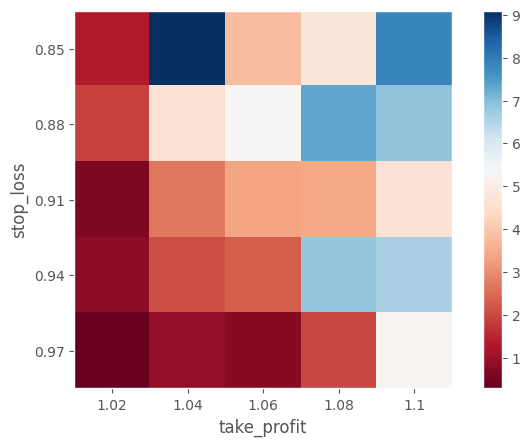

In [160]:
import numpy as np
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def build_heatmap(data, xs, ys, baseline=1.0):
    
    heat_data = [data[x, y] for y in ys for x in xs]
    
    X, Y = np.meshgrid(xs, ys)
    Z = np.array(heat_data).reshape(X.shape)

    # heatmap
    plt.rcParams["figure.figsize"] = (8, 5)
    plt.xticks(range(len(xs)), xs)
    plt.yticks(range(len(ys)), ys)
#     plt.xticks(range(len(xs)), [f"+{(x-1)*100:.0f}%" for x in xs])
#     plt.yticks(range(len(ys)), [f"-{(1-y)*100:.0f}%" for y in ys])
    plt.grid(False)
    plt.title('')
    plt.xlabel('take_profit')
    plt.ylabel('stop_loss')
    heat = plt.imshow(Z, cmap='RdBu', norm=MidpointNormalize(midpoint=baseline))
    plt.colorbar(heat)
    plt.show()

heat_data = {}
for (tp, sl), df_sim in results.items():
    heat_data[tp, sl] = df_sim.iloc[-1]['stake']

build_heatmap(heat_data, xs=tp_range, ys=sl_range, baseline=market)

best_tp: 1.04
best_sl: 0.85


,close,close_ema26_norm,close_ma200_norm,stake,action
2021-01-02 16:58:00,0.019650,0.979587,0.982327,1.038752,PROFIT
2021-01-02 17:33:00,0.020520,0.978751,0.945775,1.079006,PROFIT
2021-01-03 10:40:00,0.021621,0.957018,0.933900,1.120819,PROFIT
2021-01-03 12:44:00,0.022642,0.968460,0.934226,1.164253,PROFIT
2021-01-03 13:09:00,0.023628,0.973092,0.909039,1.209370,PROFIT
...,...,...,...,...,...
2021-05-29 17:55:00,0.100640,0.987530,0.988177,8.335608,PROFIT
2021-05-29 22:48:00,0.098250,0.990752,0.971416,8.658629,PROFIT
2021-05-30 04:00:00,0.099270,0.991845,0.970958,8.994169,PROFIT
2021-05-30 06:46:00,0.109860,0.973799,0.924798,9.342711,PROFIT


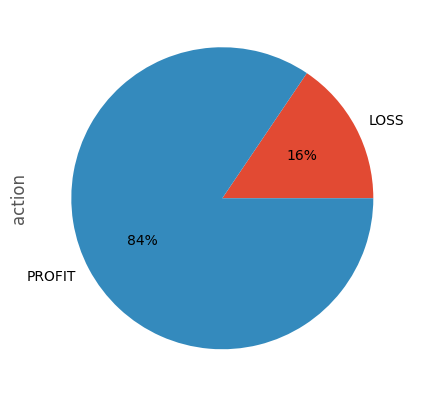

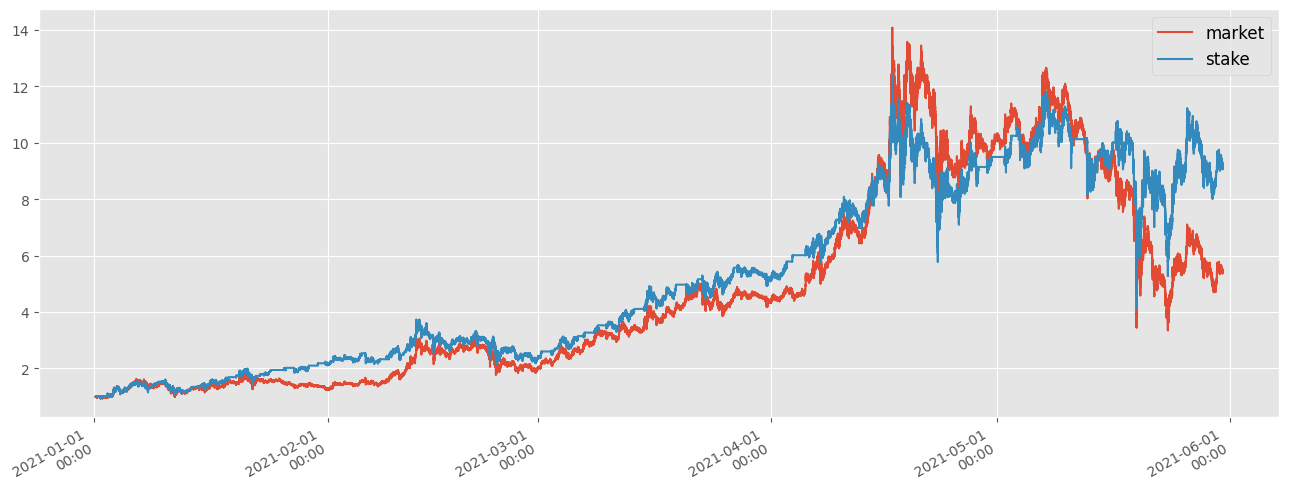

In [154]:
best_tp, best_sl = sorted(results.items(), key=lambda item: item[1].iloc[-1]['stake'], reverse=True)[0][0]
print(f"best_tp: {best_tp}\nbest_sl: {best_sl}")

show_simulation(results[best_tp, best_sl])

## Test on new date range

In [155]:
START_TEST = '20210601000000'

Simulating...: 100%|█████████████████████████████████████| 215412/215412 [00:14<00:00, 14382.98it/s]


,close,close_ema26_norm,close_ma200_norm,stake,action
2021-06-01 14:30:00,0.12369,0.971726,0.986062,1.038752,PROFIT
2021-06-02 14:30:00,0.12714,0.988738,0.978024,1.079006,PROFIT
2021-06-04 08:19:00,0.12524,1.027591,1.090738,0.916054,LOSS
2021-06-04 08:38:00,0.13112,0.981764,1.030323,0.951553,PROFIT
2021-06-05 01:50:00,0.13587,0.985754,0.970215,0.988428,PROFIT
...,...,...,...,...,...
2021-10-14 01:14:00,0.11823,0.986659,0.972460,1.027516,PROFIT
2021-10-17 16:00:00,0.12698,0.981652,0.941913,1.067335,PROFIT
2021-10-21 11:11:00,0.13213,0.982857,0.948170,1.108696,PROFIT
2021-10-21 14:34:00,0.13597,0.984988,0.969239,1.151660,PROFIT


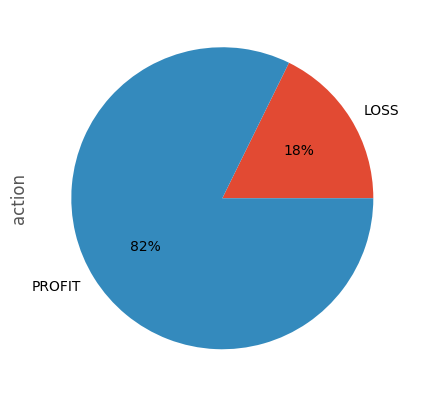

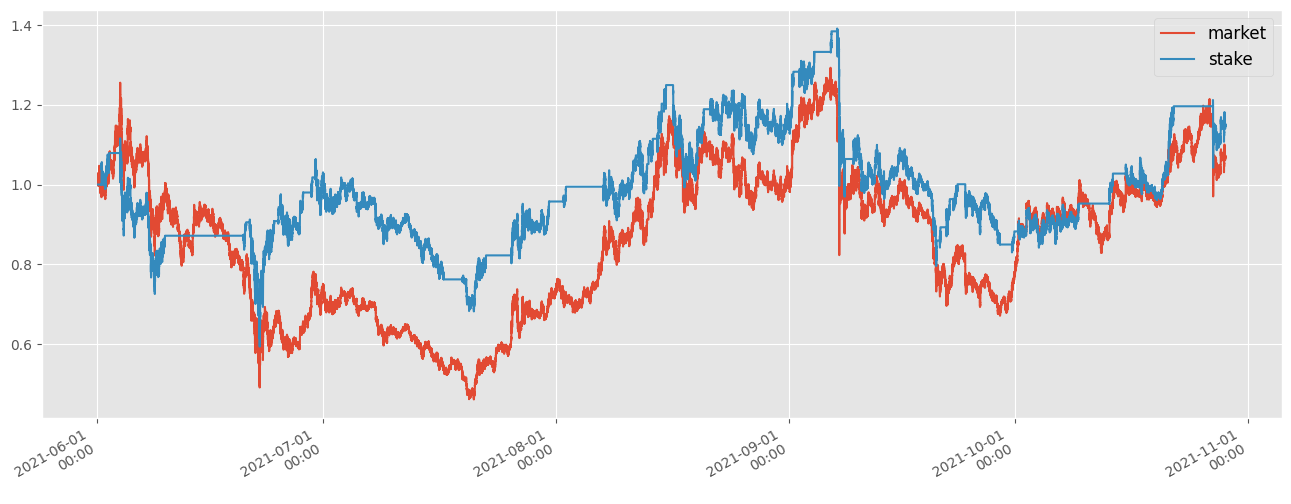

In [156]:
_ = run_simulation(SYMBOL, START_TEST, DAYS, is_good_signal, freq=FREQ, 
                           target=best_tp, stop=best_sl, hrs_frozen=0, fees=FEES)